# Import Library

In [1]:
# From: https://machinelearningmastery.com/exploratory-configuration-multilayer-perceptron-network-time-series-forecasting/
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from datetime import datetime
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error
from math import sqrt

from tensorflow.keras.layers import LSTM

# Function Plot hasil

In [2]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss (MSE)')
  plt.legend()
  plt.grid(True)

# Dataset daily-min-temperature

## Parser dan Read dataset

In [3]:
def parser(x):
	return datetime.strptime(x, '%Y-%m-%d')

In [4]:
dataset = pd.read_csv('/content/drive/My Drive/BCML/daily-min-temperatures.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

dataset.head()

Date
1981-01-01    20.7
1981-01-02    17.9
1981-01-03    18.8
1981-01-04    14.6
1981-01-05    15.8
Name: Temp, dtype: float64

## Plot dataset

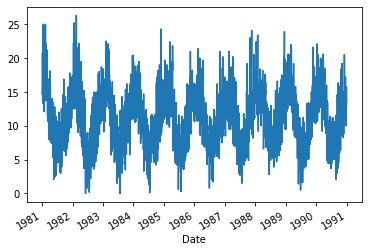

In [5]:
dataset.plot()
plt.show()

## Processing Time series

In [6]:
def timeseries_to_supervised(data, lag=1):
	df = pd.DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = pd.concat(columns, axis=1)
	return df

def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

In [7]:
lag = 1

raw_values = dataset.values
diff_values = difference(raw_values, 1)

diff_values

0      -2.8
1       0.9
2      -4.2
3       1.2
4       0.0
       ... 
3644   -0.6
3645   -0.4
3646   -0.1
3647    2.2
3648   -2.7
Length: 3649, dtype: float64

In [8]:
supervised = timeseries_to_supervised(diff_values, lag)
supervised

,0,0
0,NaN,-2.8
1,-2.8,0.9
2,0.9,-4.2
3,-4.2,1.2
4,1.2,0.0
...,...,...
3644,1.7,-0.6
3645,-0.6,-0.4
3646,-0.4,-0.1
3647,-0.1,2.2


In [9]:
supervised_values = supervised.values[lag:,:]
supervised_values

array([[-2.8,  0.9],
       [ 0.9, -4.2],
       [-4.2,  1.2],
       ...,
       [-0.4, -0.1],
       [-0.1,  2.2],
       [ 2.2, -2.7]])

In [10]:
split_percentage = 0.75

train_size = int(split_percentage * len(supervised_values))

train, test = supervised_values[0:train_size], supervised_values[train_size:len(supervised_values)]

In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1)) # Range hasil scaling menjadi angka diantara -1 hingga 1
scaler = scaler.fit(train)

train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

In [12]:
train_scaled

array([[-0.11607143,  0.21428571],
       [ 0.21428571, -0.24107143],
       [-0.24107143,  0.24107143],
       ...,
       [-0.16071429,  0.375     ],
       [ 0.375     ,  0.125     ],
       [ 0.125     , -0.16071429]])

## Modeling

### Baseline

In [13]:
neurons = 1
epoch = 1000
batch_size = 32

feature_train, label_train = train_scaled[:, 0:-1], train_scaled[:, -1]
feature_test, label_test = test_scaled[:, 0:-1], test_scaled[:, -1]

model = Sequential()
model.add(Dense(neurons, activation='relu', input_dim=feature_train.shape[1]))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(feature_train, label_train, epochs=epoch, batch_size=batch_size, validation_data=(feature_test, label_test))

Epoch 1/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0664 - val_loss: 0.0561
Epoch 2/1000
86/86 [==============================] - 0s 839us/step - loss: 0.0599 - val_loss: 0.0545
Epoch 3/1000
86/86 [==============================] - 0s 847us/step - loss: 0.0594 - val_loss: 0.0544
Epoch 4/1000
86/86 [==============================] - 0s 981us/step - loss: 0.0592 - val_loss: 0.0543
Epoch 5/1000
86/86 [==============================] - 0s 937us/step - loss: 0.0591 - val_loss: 0.0542
Epoch 6/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0590 - val_loss: 0.0542
Epoch 7/1000
86/86 [==============================] - 0s 941us/step - loss: 0.0590 - val_loss: 0.0542
Epoch 8/1000
86/86 [==============================] - 0s 960us/step - loss: 0.0590 - val_loss: 0.0542
Epoch 9/1000
86/86 [==============================] - 0s 931us/step - loss: 0.0590 - val_loss: 0.0542
Epoch 10/1000
86/86 [==============================] - 0s 862us/step - loss: 0.0589 - 

In [14]:
loss = model.evaluate(feature_test, label_test, verbose=2)

print("Test loss:", loss)

29/29 - 0s - loss: 0.0540
Test loss: 0.05398981645703316


In [15]:
history_dataframe = pd.DataFrame(history.history)
history_dataframe['epoch'] = history.epoch
history_dataframe.sort_values(by='val_loss', ascending=True)

,loss,val_loss,epoch
238,0.058748,0.053976,238
453,0.058748,0.053976,453
505,0.058796,0.053976,505
603,0.058731,0.053976,603
764,0.058794,0.053977,764
...,...,...,...
4,0.059083,0.054231,4
3,0.059230,0.054280,3
2,0.059445,0.054366,2
1,0.059935,0.054529,1


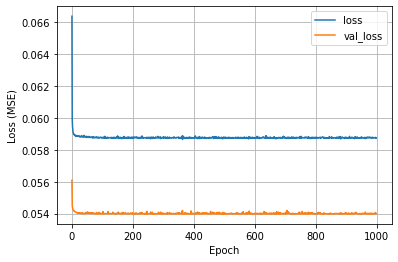

In [16]:
plot_loss(history) # epoch vs loss graph

### Deeper

In [17]:
neurons = 1
epoch = 1000
batch_size = 32

deeper_model = Sequential()
deeper_model.add(Dense(neurons, activation='relu', input_dim=feature_train.shape[1]))
deeper_model.add(Dense(5, activation='relu'))
deeper_model.add(Dense(1))
deeper_model.compile(loss='mean_squared_error', optimizer='adam')
deeper_model_history = deeper_model.fit(feature_train, label_train, epochs=epoch, batch_size=batch_size, validation_data=(feature_test, label_test))

Epoch 1/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0663 - val_loss: 0.0556
Epoch 2/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0601 - val_loss: 0.0552
Epoch 3/1000
86/86 [==============================] - 0s 893us/step - loss: 0.0598 - val_loss: 0.0550
Epoch 4/1000
86/86 [==============================] - 0s 813us/step - loss: 0.0597 - val_loss: 0.0549
Epoch 5/1000
86/86 [==============================] - 0s 833us/step - loss: 0.0595 - val_loss: 0.0547
Epoch 6/1000
86/86 [==============================] - 0s 810us/step - loss: 0.0594 - val_loss: 0.0546
Epoch 7/1000
86/86 [==============================] - 0s 819us/step - loss: 0.0592 - val_loss: 0.0546
Epoch 8/1000
86/86 [==============================] - 0s 943us/step - loss: 0.0593 - val_loss: 0.0544
Epoch 9/1000
86/86 [==============================] - 0s 950us/step - loss: 0.0591 - val_loss: 0.0543
Epoch 10/1000
86/86 [==============================] - 0s 809us/step - loss: 0.0591 - 

In [18]:
deeper_history_dataframe = pd.DataFrame(deeper_model_history.history)
deeper_history_dataframe['epoch'] = deeper_model_history.epoch
deeper_history_dataframe.sort_values(by='val_loss', ascending=True)

,loss,val_loss,epoch
402,0.058752,0.053977,402
693,0.058766,0.053977,693
883,0.058751,0.053978,883
428,0.058780,0.053978,428
759,0.058774,0.053978,759
...,...,...,...
4,0.059546,0.054666,4
3,0.059669,0.054934,3
2,0.059816,0.054998,2
1,0.060114,0.055194,1


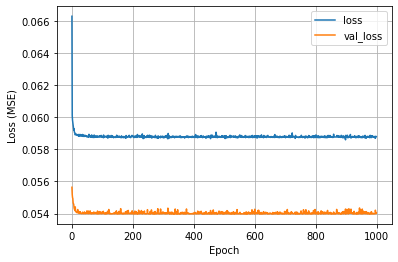

In [19]:
plot_loss(deeper_model_history) # epoch vs loss graph

### Wider

In [20]:
neurons = 50
epoch = 1000
batch_size = 32

wider_model = Sequential()
wider_model.add(Dense(neurons, activation='relu', input_dim=feature_train.shape[1]))
wider_model.add(Dense(1))
wider_model.compile(loss='mean_squared_error', optimizer='adam')
wider_model_history = wider_model.fit(feature_train, label_train, epochs=epoch, batch_size=batch_size, validation_data=(feature_test, label_test))

Epoch 1/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0642 - val_loss: 0.0540
Epoch 2/1000
86/86 [==============================] - 0s 756us/step - loss: 0.0585 - val_loss: 0.0539
Epoch 3/1000
86/86 [==============================] - 0s 751us/step - loss: 0.0583 - val_loss: 0.0539
Epoch 4/1000
86/86 [==============================] - 0s 766us/step - loss: 0.0583 - val_loss: 0.0538
Epoch 5/1000
86/86 [==============================] - 0s 816us/step - loss: 0.0582 - val_loss: 0.0540
Epoch 6/1000
86/86 [==============================] - 0s 812us/step - loss: 0.0581 - val_loss: 0.0538
Epoch 7/1000
86/86 [==============================] - 0s 751us/step - loss: 0.0580 - val_loss: 0.0538
Epoch 8/1000
86/86 [==============================] - 0s 956us/step - loss: 0.0581 - val_loss: 0.0538
Epoch 9/1000
86/86 [==============================] - 0s 790us/step - loss: 0.0581 - val_loss: 0.0537
Epoch 10/1000
86/86 [==============================] - 0s 744us/step - loss: 0.0582 

In [21]:
wider_history_dataframe = pd.DataFrame(wider_model_history.history)
wider_history_dataframe['epoch'] = wider_model_history.epoch
wider_history_dataframe.sort_values(by='val_loss', ascending=True)

,loss,val_loss,epoch
251,0.057580,0.053721,251
9,0.058217,0.053726,9
11,0.057995,0.053729,11
86,0.057857,0.053732,86
91,0.057969,0.053746,91
...,...,...,...
535,0.057463,0.054562,535
842,0.057382,0.054564,842
440,0.057584,0.054588,440
830,0.057471,0.054613,830


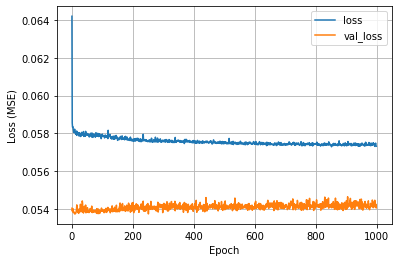

In [22]:
plot_loss(wider_model_history)

### LSTM

In [23]:
epoch = 1000
batch_size = 32

# Reshape menjadi (jumlah sample, time steps, jumlah feature)
# Time steps: jumlah lag, gunakan default 1
# https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
feature_train_reshaped = np.reshape(feature_train, (feature_train.shape[0], 1, feature_train.shape[1]))
feature_test_reshaped = np.reshape(feature_test, (feature_test.shape[0], 1, feature_test.shape[1]))

lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_dim=feature_train.shape[1])) # 50 LSTM Block
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

lstm_model_history = lstm_model.fit(feature_train_reshaped, label_train, epochs=epoch, batch_size=batch_size, validation_data=(feature_test_reshaped, label_test))

Epoch 1/1000
86/86 [==============================] - 0s 3ms/step - loss: 0.0655 - val_loss: 0.0550
Epoch 2/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0593 - val_loss: 0.0544
Epoch 3/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0589 - val_loss: 0.0543
Epoch 4/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0587 - val_loss: 0.0539
Epoch 5/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0587 - val_loss: 0.0539
Epoch 6/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0586 - val_loss: 0.0539
Epoch 7/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0585 - val_loss: 0.0539
Epoch 8/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0584 - val_loss: 0.0540
Epoch 9/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0584 - val_loss: 0.0540
Epoch 10/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0583 - val_loss: 0.0539

In [24]:
lstm_history_dataframe = pd.DataFrame(lstm_model_history.history)
lstm_history_dataframe['epoch'] = lstm_model_history.epoch
lstm_history_dataframe.sort_values(by='val_loss', ascending=True)

,loss,val_loss,epoch
393,0.057850,0.053774,393
472,0.057798,0.053776,472
413,0.057911,0.053778,413
443,0.057896,0.053779,443
394,0.057931,0.053782,394
...,...,...,...
1,0.059304,0.054384,1
255,0.058003,0.054385,255
115,0.058043,0.054506,115
43,0.058030,0.054644,43


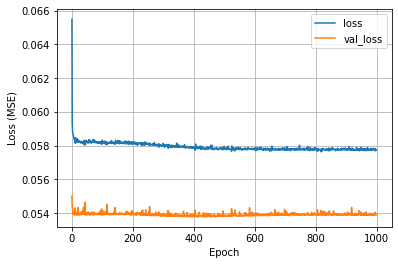

In [25]:
plot_loss(lstm_model_history)

# Kesimpulan dataset daily-min-temperature

Untuk hasil validation loss pada model-model diatas perbedaannya tidak terlalu signifikan. Akan tetapi validation loss terendah didapatkan dengan model Wider pada epoch ke-251, dimana:

Epoch = 251

Loss =	0.057580

Val_loss = 	0.053721

# Dataset birth

## Parser dan Read dataset

In [ ]:
def parser(x):
	return datetime.strptime(x, '%Y-%m-%d')

In [ ]:
dataset2 = pd.read_csv('/content/drive/My Drive/BCML/birth.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

dataset2.head()

Date
1959-01-01    35
1959-01-02    32
1959-01-03    30
1959-01-04    31
1959-01-05    44
Name: Births, dtype: int64

## Plot dataset

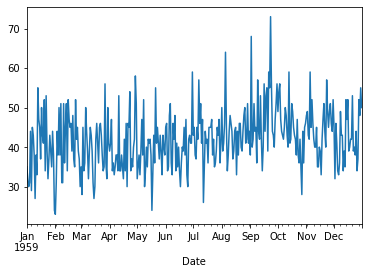

In [ ]:
dataset2.plot()
plt.show()

## Processing Time series

In [ ]:
def timeseries_to_supervised(data, lag=1):
	df = pd.DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = pd.concat(columns, axis=1)
	return df

def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset2)):
		value = dataset2[i] - dataset2[i - interval]
		diff.append(value)
	return pd.Series(diff)

In [ ]:
lag = 1

raw_values = dataset2.values
diff_values = difference(raw_values, 1)

diff_values

0      -3
1      -2
2       1
3      13
4     -15
       ..
359     3
360    15
361    -4
362     7
363    -5
Length: 364, dtype: int64

In [ ]:
supervised = timeseries_to_supervised(diff_values, lag)
supervised

,0,0
0,NaN,-3
1,-3.0,-2
2,-2.0,1
3,1.0,13
4,13.0,-15
...,...,...
359,-10.0,3
360,3.0,15
361,15.0,-4
362,-4.0,7


In [ ]:
supervised_values = supervised.values[lag:,:]
supervised_values

array([[ -3.,  -2.],
       [ -2.,   1.],
       [  1.,  13.],
       [ 13., -15.],
       [-15.,  16.],
       [ 16.,  -2.],
       [ -2.,  -5.],
       [ -5., -11.],
       [-11.,  11.],
       [ 11.,  -5.],
       [ -5.,  22.],
       [ 22.,  -8.],
       [ -8.,  -2.],
       [ -2.,  -8.],
       [ -8.,  13.],
       [ 13.,  -7.],
       [ -7.,  -2.],
       [ -2.,  11.],
       [ 11., -18.],
       [-18.,  19.],
       [ 19., -14.],
       [-14.,  -7.],
       [ -7.,   5.],
       [  5.,   6.],
       [  6.,  -4.],
       [ -4.,  -4.],
       [ -4.,   9.],
       [  9.,  -6.],
       [ -6., -14.],
       [-14.,  -1.],
       [ -1.,   8.],
       [  8.,  13.],
       [ 13.,  -6.],
       [ -6.,  12.],
       [ 12., -12.],
       [-12.,  13.],
       [ 13., -20.],
       [-20.,   0.],
       [  0.,  20.],
       [ 20., -15.],
       [-15.,   9.],
       [  9.,   6.],
       [  6., -17.],
       [-17.,  18.],
       [ 18.,  -5.],
       [ -5.,  -2.],
       [ -2.,   1.],
       [  1.,

In [ ]:
split_percentage = 0.75

train_size = int(split_percentage * len(supervised_values))

train, test = supervised_values[0:train_size], supervised_values[train_size:len(supervised_values)]

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1)) # Range hasil scaling menjadi angka diantara -1 hingga 1
scaler = scaler.fit(train)

train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

In [ ]:
train_scaled

array([[-1.37931034e-01, -1.03448276e-01],
       [-1.03448276e-01, -6.93889390e-17],
       [-6.93889390e-17,  4.13793103e-01],
       [ 4.13793103e-01, -5.51724138e-01],
       [-5.51724138e-01,  5.17241379e-01],
       [ 5.17241379e-01, -1.03448276e-01],
       [-1.03448276e-01, -2.06896552e-01],
       [-2.06896552e-01, -4.13793103e-01],
       [-4.13793103e-01,  3.44827586e-01],
       [ 3.44827586e-01, -2.06896552e-01],
       [-2.06896552e-01,  7.24137931e-01],
       [ 7.24137931e-01, -3.10344828e-01],
       [-3.10344828e-01, -1.03448276e-01],
       [-1.03448276e-01, -3.10344828e-01],
       [-3.10344828e-01,  4.13793103e-01],
       [ 4.13793103e-01, -2.75862069e-01],
       [-2.75862069e-01, -1.03448276e-01],
       [-1.03448276e-01,  3.44827586e-01],
       [ 3.44827586e-01, -6.55172414e-01],
       [-6.55172414e-01,  6.20689655e-01],
       [ 6.20689655e-01, -5.17241379e-01],
       [-5.17241379e-01, -2.75862069e-01],
       [-2.75862069e-01,  1.37931034e-01],
       [ 1.

## Modeling

### Baseline

In [ ]:
neurons = 1
epoch = 1000
batch_size = 32

feature_train, label_train = train_scaled[:, 0:-1], train_scaled[:, -1]
feature_test, label_test = test_scaled[:, 0:-1], test_scaled[:, -1]

model2 = Sequential()
model2.add(Dense(neurons, activation='relu', input_dim=feature_train.shape[1]))
model2.add(Dense(1))
model2.compile(loss='mean_squared_error', optimizer='adam')
history2 = model2.fit(feature_train, label_train, epochs=epoch, batch_size=batch_size, validation_data=(feature_test, label_test))

Epoch 1/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1643 - val_loss: 0.1065
Epoch 2/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1576 - val_loss: 0.1009
Epoch 3/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1503 - val_loss: 0.0964
Epoch 4/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1453 - val_loss: 0.0921
Epoch 5/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1397 - val_loss: 0.0886
Epoch 6/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1358 - val_loss: 0.0854
Epoch 7/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1316 - val_loss: 0.0829
Epoch 8/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1282 - val_loss: 0.0806
Epoch 9/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1253 - val_loss: 0.0788
Epoch 10/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1229 - val_loss: 0.0772
Epoch 11/1000
9/9 

In [ ]:
loss2 = model2.evaluate(feature_test, label_test, verbose=2)

print("Test loss:", loss)

3/3 - 0s - loss: 0.0568
Test loss: 0.056795503944158554


In [ ]:
history_dataframe2 = pd.DataFrame(history2.history)
history_dataframe2['epoch'] = history.epoch
history_dataframe2.sort_values(by='val_loss', ascending=True)

,loss,val_loss,epoch
313,0.087268,0.056726,313
312,0.087256,0.056727,312
303,0.087348,0.056727,303
302,0.087456,0.056730,302
306,0.087341,0.056733,306
...,...,...,...
4,0.139735,0.088598,4
3,0.145270,0.092092,3
2,0.150285,0.096382,2
1,0.157564,0.100870,1


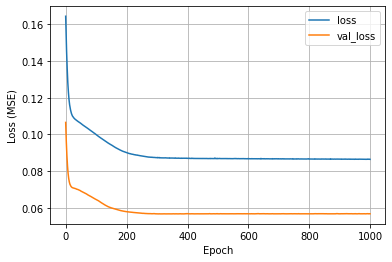

In [ ]:
plot_loss(history2) # epoch vs loss graph

### Deeper

In [ ]:
neurons = 1
epoch = 1000
batch_size = 32

deeper_model2 = Sequential()
deeper_model2.add(Dense(neurons, activation='relu', input_dim=feature_train.shape[1]))
deeper_model2.add(Dense(5, activation='relu'))
deeper_model2.add(Dense(1))
deeper_model2.compile(loss='mean_squared_error', optimizer='adam')
deeper_model_history2 = deeper_model2.fit(feature_train, label_train, epochs=epoch, batch_size=batch_size, validation_data=(feature_test, label_test))

Epoch 1/1000
9/9 [==============================] - 0s 10ms/step - loss: 0.1257 - val_loss: 0.0776
Epoch 2/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1223 - val_loss: 0.0751
Epoch 3/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1192 - val_loss: 0.0734
Epoch 4/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1170 - val_loss: 0.0722
Epoch 5/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1153 - val_loss: 0.0713
Epoch 6/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1141 - val_loss: 0.0707
Epoch 7/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1131 - val_loss: 0.0702
Epoch 8/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1125 - val_loss: 0.0698
Epoch 9/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1119 - val_loss: 0.0697
Epoch 10/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1116 - val_loss: 0.0696
Epoch 11/1000
9/9 

In [ ]:
deeper_history_dataframe2 = pd.DataFrame(deeper_model_history2.history)
deeper_history_dataframe2['epoch'] = deeper_model_history2.epoch
deeper_history_dataframe2.sort_values(by='val_loss', ascending=True)

,loss,val_loss,epoch
122,0.081794,0.053497,122
121,0.082052,0.053498,121
123,0.081659,0.053506,123
120,0.082198,0.053537,120
119,0.082590,0.053552,119
...,...,...,...
4,0.115315,0.071347,4
3,0.117031,0.072231,3
2,0.119238,0.073425,2
1,0.122271,0.075088,1


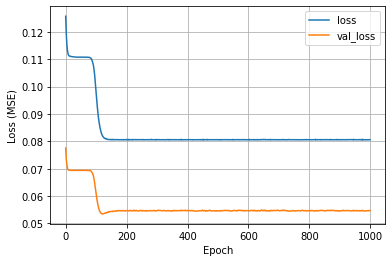

In [ ]:
plot_loss(deeper_model_history2) # epoch vs loss graph

### Wider

In [ ]:
neurons = 50
epoch = 1000
batch_size = 32

wider_model2 = Sequential()
wider_model2.add(Dense(neurons, activation='relu', input_dim=feature_train.shape[1]))
wider_model2.add(Dense(1))
wider_model2.compile(loss='mean_squared_error', optimizer='adam')
wider_model_history2 = wider_model2.fit(feature_train, label_train, epochs=epoch, batch_size=batch_size, validation_data=(feature_test, label_test))

Epoch 1/1000
9/9 [==============================] - 0s 8ms/step - loss: 0.1052 - val_loss: 0.0642
Epoch 2/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.0964 - val_loss: 0.0599
Epoch 3/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0907 - val_loss: 0.0576
Epoch 4/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.0879 - val_loss: 0.0567
Epoch 5/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.0862 - val_loss: 0.0563
Epoch 6/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.0853 - val_loss: 0.0558
Epoch 7/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.0846 - val_loss: 0.0557
Epoch 8/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0839 - val_loss: 0.0553
Epoch 9/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.0833 - val_loss: 0.0552
Epoch 10/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.0830 - val_loss: 0.0549
Epoch 11/1000
9/9 [

In [ ]:
wider_history_dataframe2 = pd.DataFrame(wider_model_history2.history)
wider_history_dataframe2['epoch'] = wider_model_history2.epoch
wider_history_dataframe2.sort_values(by='val_loss', ascending=True)

,loss,val_loss,epoch
40,0.080864,0.054021,40
19,0.081218,0.054137,19
18,0.081393,0.054145,18
240,0.080472,0.054203,240
161,0.081138,0.054208,161
...,...,...,...
596,0.080470,0.056347,596
3,0.087872,0.056670,3
2,0.090694,0.057574,2
1,0.096373,0.059862,1


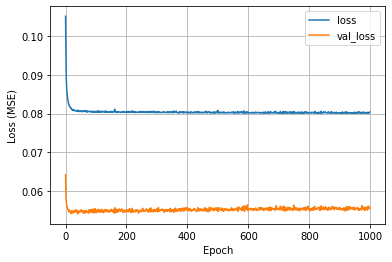

In [ ]:
plot_loss(wider_model_history2)

### LSTM

In [ ]:
epoch = 1000
batch_size = 32

# Reshape menjadi (jumlah sample, time steps, jumlah feature)
# Time steps: jumlah lag, gunakan default 1
# https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
feature_train_reshaped = np.reshape(feature_train, (feature_train.shape[0], 1, feature_train.shape[1]))
feature_test_reshaped = np.reshape(feature_test, (feature_test.shape[0], 1, feature_test.shape[1]))

lstm_model2 = Sequential()
lstm_model2.add(LSTM(50, activation='relu', input_dim=feature_train.shape[1])) # 50 LSTM Block
lstm_model2.add(Dense(1))
lstm_model2.compile(optimizer='adam', loss='mean_squared_error')

lstm_model_history2 = lstm_model2.fit(feature_train_reshaped, label_train, epochs=epoch, batch_size=batch_size, validation_data=(feature_test_reshaped, label_test))

Epoch 1/1000
9/9 [==============================] - 0s 17ms/step - loss: 0.1121 - val_loss: 0.0691
Epoch 2/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1090 - val_loss: 0.0675
Epoch 3/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1066 - val_loss: 0.0662
Epoch 4/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1046 - val_loss: 0.0651
Epoch 5/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1029 - val_loss: 0.0641
Epoch 6/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1011 - val_loss: 0.0633
Epoch 7/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0995 - val_loss: 0.0625
Epoch 8/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0981 - val_loss: 0.0617
Epoch 9/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0965 - val_loss: 0.0609
Epoch 10/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0950 - val_loss: 0.0601
Epoch 11/1000
9/9 

In [ ]:
lstm_history_dataframe2 = pd.DataFrame(lstm_model_history2.history)
lstm_history_dataframe2['epoch'] = lstm_model_history2.epoch
lstm_history_dataframe2.sort_values(by='val_loss', ascending=True)

,loss,val_loss,epoch
200,0.080473,0.054276,200
280,0.080386,0.054358,280
326,0.080425,0.054363,326
279,0.080394,0.054373,279
199,0.080440,0.054377,199
...,...,...,...
4,0.102929,0.064142,4
3,0.104646,0.065102,3
2,0.106585,0.066178,2
1,0.108979,0.067454,1


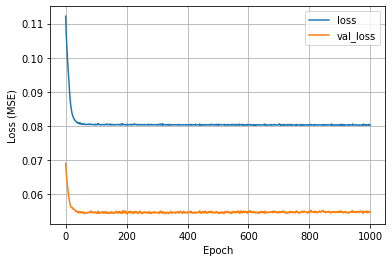

In [ ]:
plot_loss(lstm_model_history2)

# Kesimpulan dataset birth

Untuk hasil validation loss pada model-model diatas perbedaannya tidak terlalu signifikan pula. Akan tetapi validation loss terendah didapatkan dengan model Deeper pada epoch ke-122, dimana:

Epoch = 122

Loss =	0.081794

Val_loss = 	0.053497